In [1]:
import pickle
import numpy as np
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
from PIL import Image
import json
from scipy import ndimage
import math
import random
import cv2
import matplotlib.pyplot as plt
import copy
import csv

from UnariesNet_orien import unariesNet
import MyConfig_orien as MyConfig
import Config
import IO_funcs
import getCamM
import geoFuncs
import drawLib
import GroupCluster

%load_ext autoreload
%autoreload 2

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN Z (CNMeM is disabled, cuDNN 5110)
/home/pichen/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
unaryModel = unariesNet(load_pretrained = True, training = False)

param save at =  ../Unaries_orien_newGT2/trainedModels/
Preparing room
part root folder:  ../../../../../cvlabdata2/home/pichen/Potentials/Parts/Run_transfer/Salsa_2/
pom_file_path:  ../../../dataset/Salsa/rectangles80x80.pom
img_list from 2000  to 2990
img_path_format:  ../../../../../cvlabdata2/home/pichen/Potentials/Parts/Run_transfer/Salsa_2/c%d/%d.npy
Initializing Unaries Network


VGG/VGGNet.py:46: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  p1 = theano.tensor.signal.pool.pool_2d(c12, ds = (2,2), st = (2,2), ignore_border=True)
VGG/VGGNet.py:46: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  p1 = theano.tensor.signal.pool.pool_2d(c12, ds = (2,2), st = (2,2), ignore_border=True)
VGG/VGGNet.py:50: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  p2 = theano.tensor.signal.pool.pool_2d(c22, ds = (2,2), st = (2,2), ignore_border=True)
VGG/VGGNet.py:50: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  p2 = theano.tensor.signal.pool.pool_2d(c22, ds = (2,2), st = (2,2), ignore_border=True)
VGG/VGGNet.py:55: UserWarning: DEPRECATION: the 

loading pretrained params for bbox detection
../Unaries_orien_newGT2/trainedModels/params_Unaries_55.pickle
../Unaries_orien_newGT2/trainedModels/params_VGG_55.pickle


In [3]:
#load detection GT on POM
all_detections = np.loadtxt('../../../dataset/Salsa/groundtruth.txt')
GT_b_camSpace = np.load('./GT_orien/GT_body_camSpace.npy')

#load detection results on POM ground
#1.5 200 0.5; 1.5 100 0.5
a = 1.5
p = 100
alpha_black = 0.5
GS_dat_folder = '../../../../../cvlabdata2/home/pichen/result_dat/salsa/a%f_p%d_ab%f/'%(a,p,alpha_black)
file_names = [GS_dat_folder + '%08d.dat'%fid for fid in Config.img_index_list]


In [4]:
RzTs, rvecs, tvecs, camIs, distCs = getCamM.getCamMatrixs()

rotation [ 2.24455904 -0.08139517  0.57346381] Rz angle =  0.573463809317
rotation [ 2.2346803   0.01945033 -1.54860532] Rz angle =  -1.54860531543
rotation [ 2.21293743  0.0243497  -3.10520375] Rz angle =  -3.10520374762
rotation [ 2.24282364 -0.06320134  2.26464335] Rz angle =  2.26464335169


In [5]:
with open('../../../dataset/Salsa/ffGT.json') as read_file:
    ffGTs = json.load(read_file)

In [6]:
def load_detections(fid):
    file_name = file_names[fid]
    Q_loc = IO_funcs.get_table(file_name) #score of 6400 cells on POM ground
    detections = np.where(Q_loc>0.5)[0]
    detections = detections.astype(int)
    return detections

def recID2coord(detections, H_grid):
    detections = detections.astype(int)
    pts_POM = [ [rec_ID%H_grid, rec_ID/H_grid] for rec_ID in detections  ]
    pts_POM_2d = np.array(pts_POM)
    return pts_POM_2d

def extractBoxes(cam, detections):
    GTbbox = unaryModel.room.templates_array[(cam*Config.n_parts)+(Config.n_parts-1), detections,:]
    rois_GT = np.zeros((GTbbox.shape[0],5)).astype(np.single)
    rois_GT[:,1] = GTbbox[:,1]
    rois_GT[:,2] = GTbbox[:,0]
    rois_GT[:,3] = GTbbox[:,3]
    rois_GT[:,4] = GTbbox[:,2]
    return rois_GT

In [8]:
def cam2dToWorld3d(vec2d, RzT):
    pts_cam = np.zeros((3,len(vec2d)))
    pts_cam[0:2, :] = [vec2d[:,0].transpose(), vec2d[:,1].transpose()]
    pts_world = geoFuncs.projBack2World(pts_cam, RzT)
    pts_w = pts_world[0:2, :].transpose()
    return pts_w

In [10]:
def showOrien(cam, angles, x_img, y_img, rgbImg):
    rvec = rvecs[cam]
    tvec = tvecs[cam]
    camI = camIs[cam]
    distC = distCs[cam]
    angB_Img = geoFuncs.worldAng2ImgAng(angles, rvec, tvec, camI, distC)
    pos_img = np.concatenate((np.array(x_img).reshape(-1,1), np.array(y_img).reshape(-1,1)), axis=1)
    vecB_Img = geoFuncs.pointsOnUnitWithCenter(pos_img, angB_Img, scale = 60.)
    rgbImg2 = drawLib.drawLinesInImg(pos_img, vecB_Img, rgbImg, (0,255,0), text=False)

    plt.figure(figsize=(10,10))
    plt.imshow(rgbImg)
    #plt.imsave('ffResults_cam%d_fid%d.png'%(c, fid), rgbImg)
    plt.show()

FID 0, cam 0
FID 0, cam 1
FID 0, cam 2
FID 0, cam 3
accum map


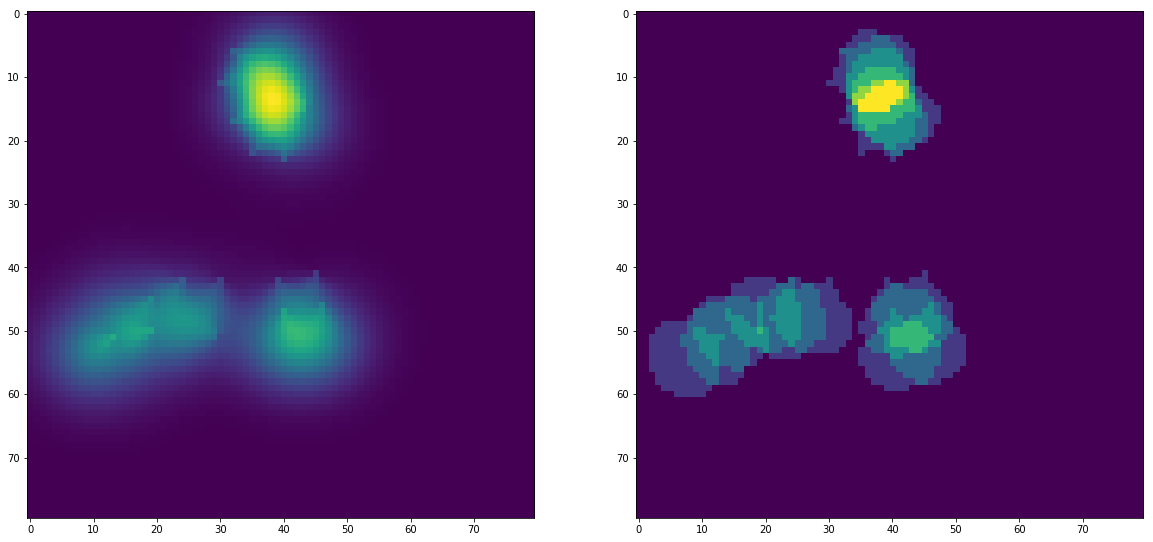

weighted accum map


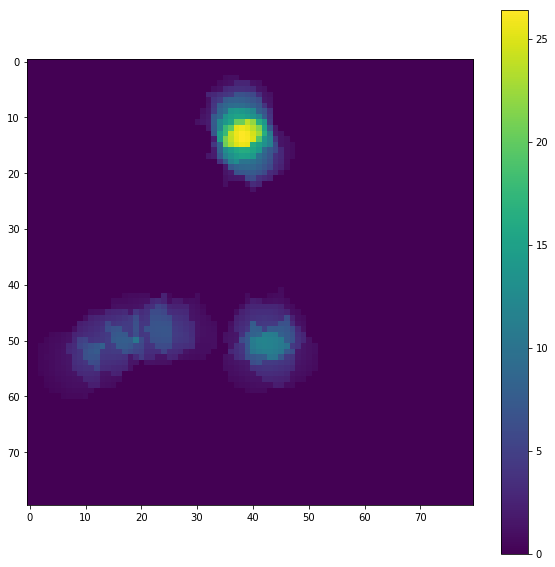

region


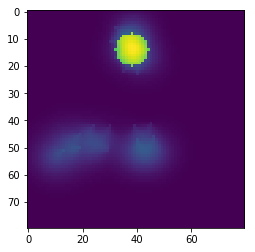

roundN 0 memberShip: [1, 2, 3, 4, 5, 6]
remain for next round


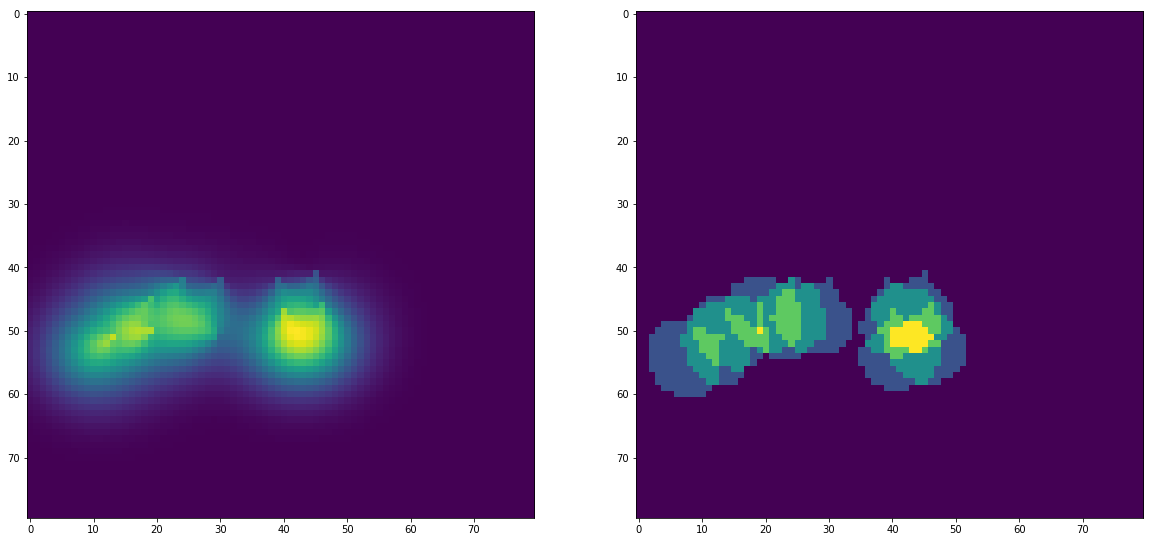

weighted accum map


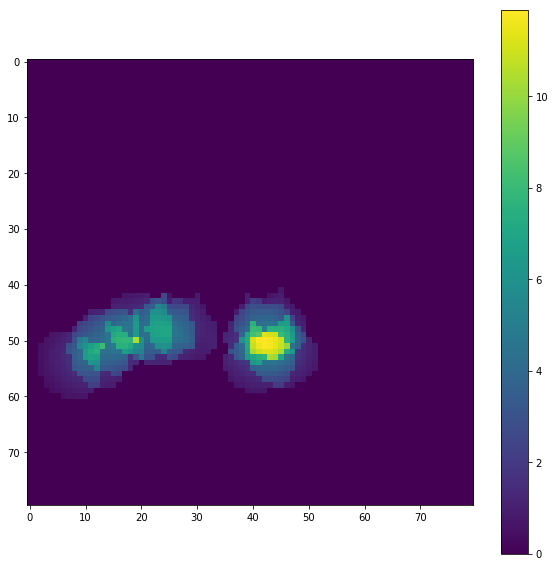

region


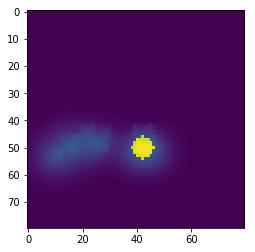

roundN 1 memberShip: [7, 10, 12, 13]
remain for next round


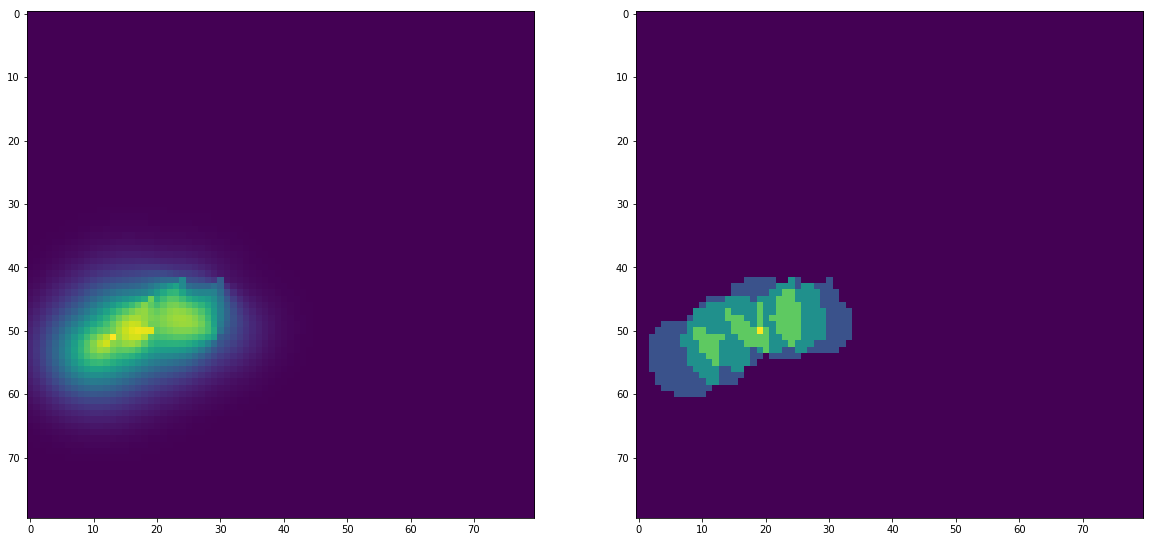

weighted accum map


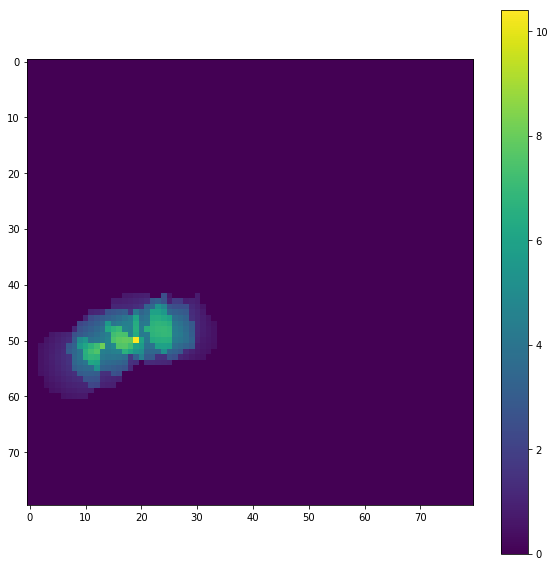

region


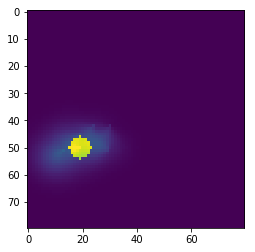

roundN 2 memberShip: [8, 9, 11, 14, 16]
remain for next round


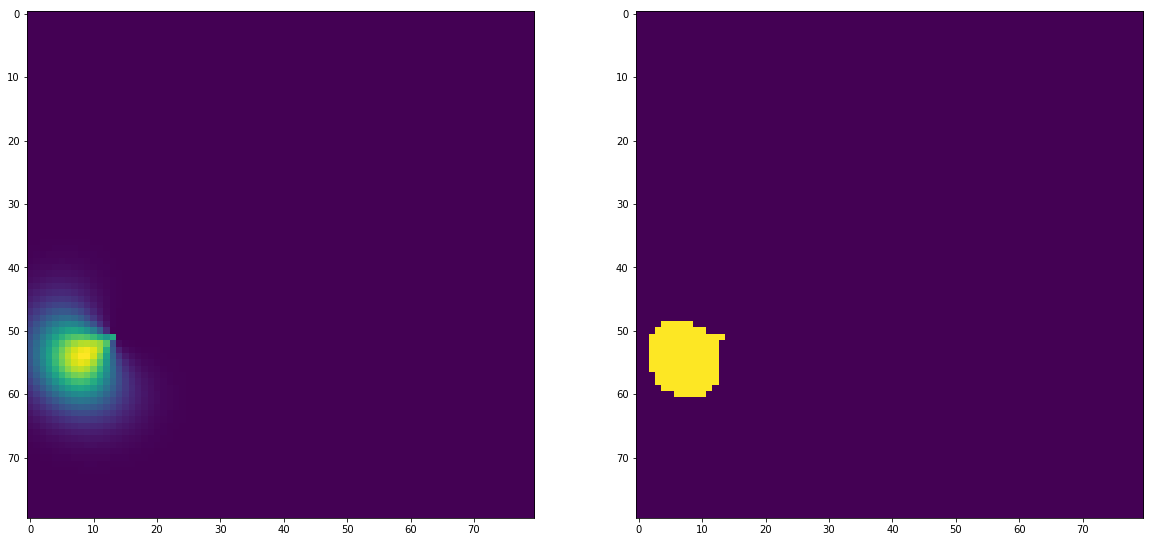

weighted accum map


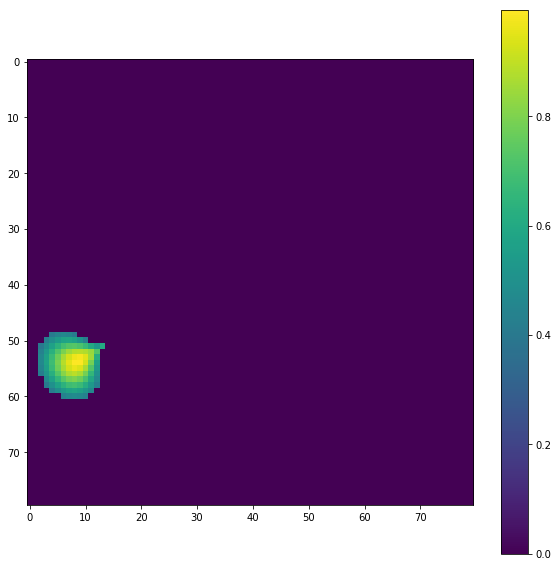

region


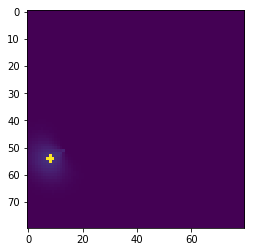

roundN 3 memberShip: [15]
remain for next round


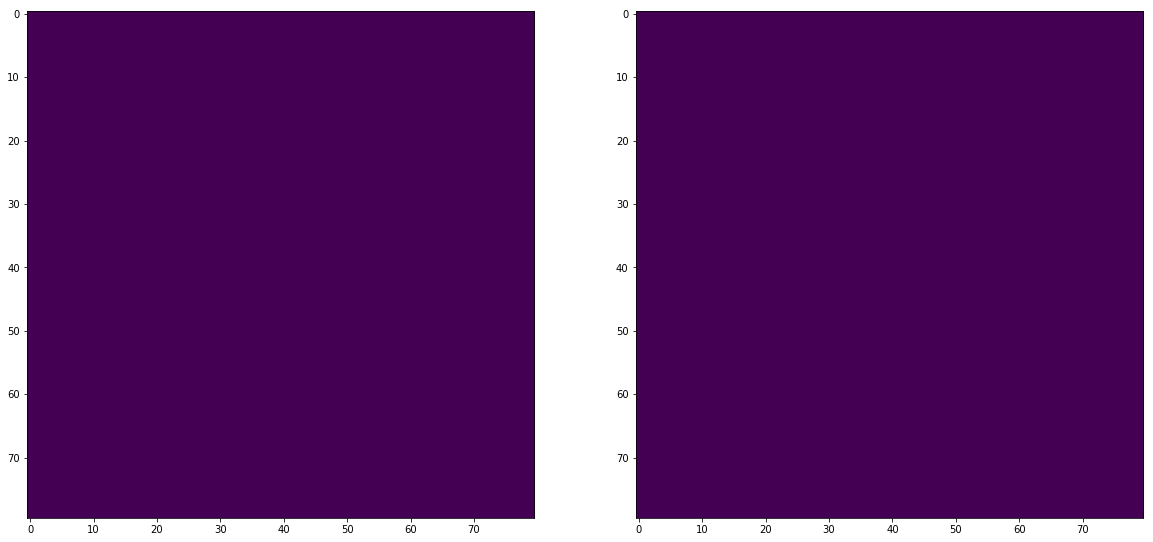

n_dets = 16, n_gts = 18


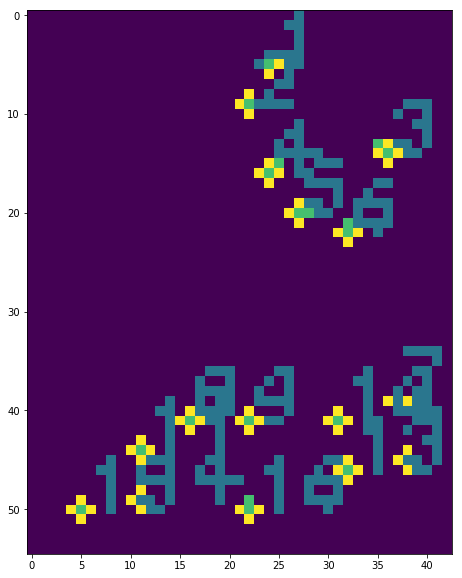

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


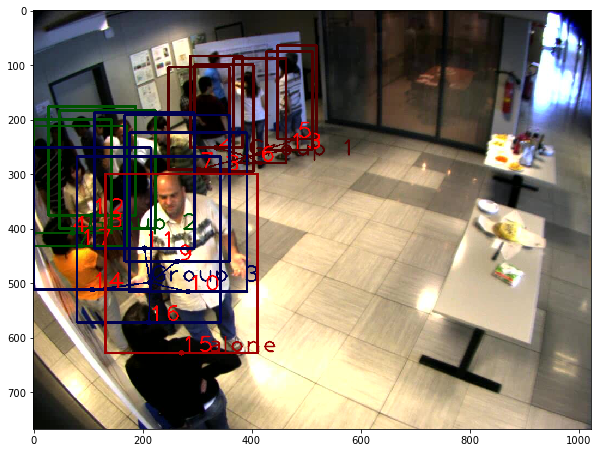

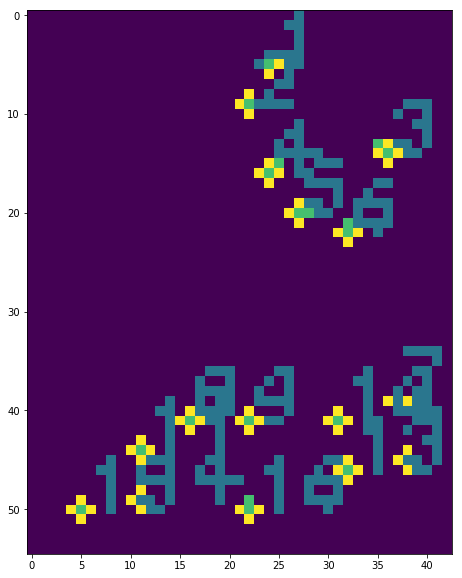

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


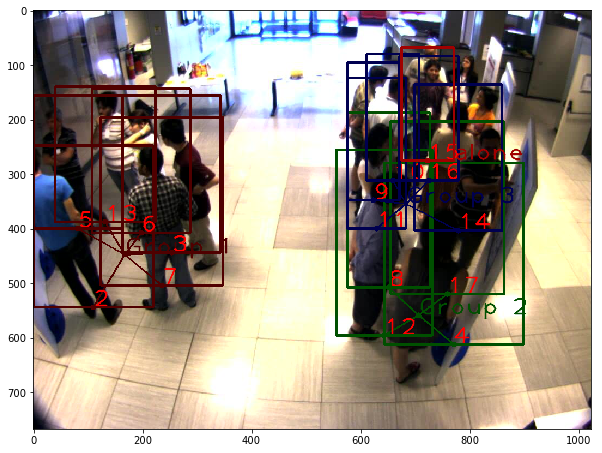

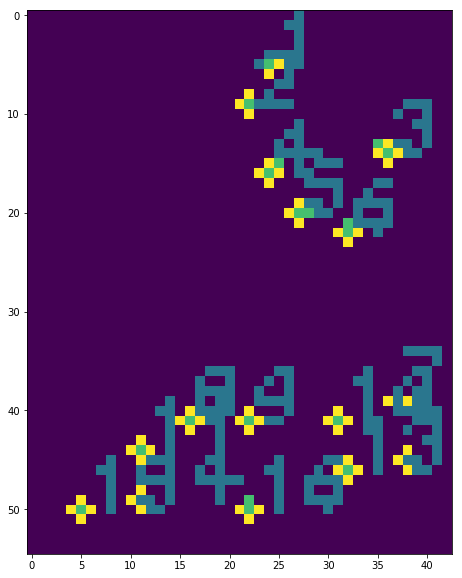

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


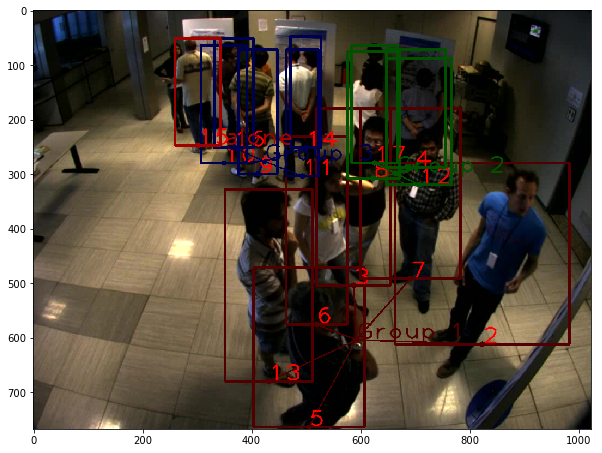

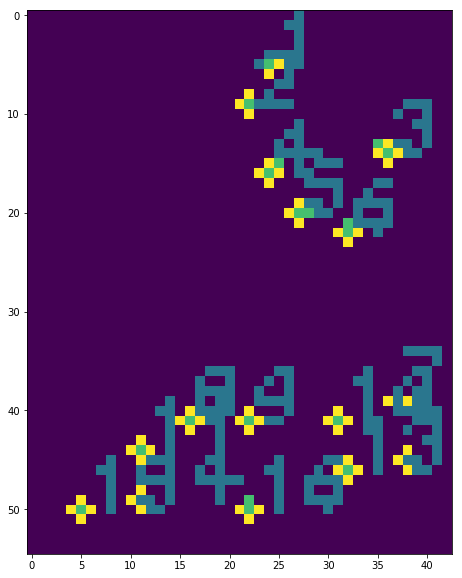

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


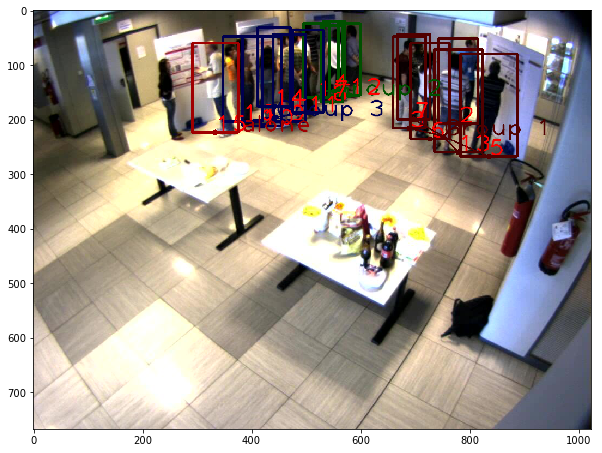

rest [[15]]
matched [[12, 8, 4, 17], [5, 13, 2, 6, 3, 7], [9, 11, 10, 16, 14]]
final members [[5, 13, 2, 6, 3, 7], [12, 8, 4, 17], [9, 11, 10, 16, 14], [15]]
GT FFormation [[8, 12, 17, 4], [1], [2, 13, 7, 3, 6, 5], [15, 9, 11, 16, 18, 10, 14]]
TP, FP, FN 3 1 1
sigma_r = 1.000000, threshold = 0.400000, kernel size = 21, F1 score = 0.750000
FID 0, cam 0
FID 0, cam 1
FID 0, cam 2
FID 0, cam 3
accum map


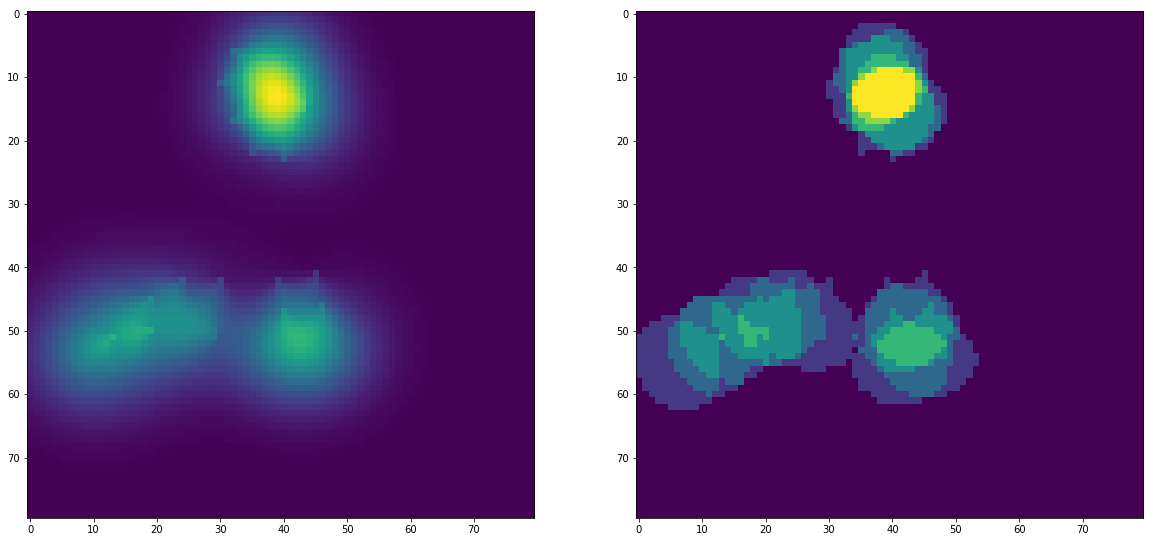

weighted accum map


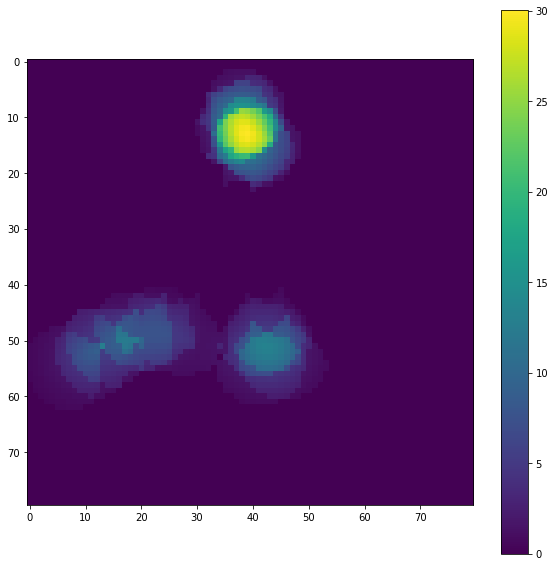

region


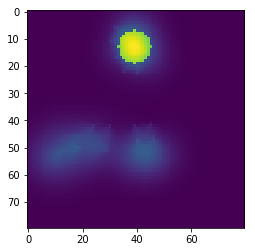

roundN 0 memberShip: [1, 2, 3, 4, 5, 6]
remain for next round


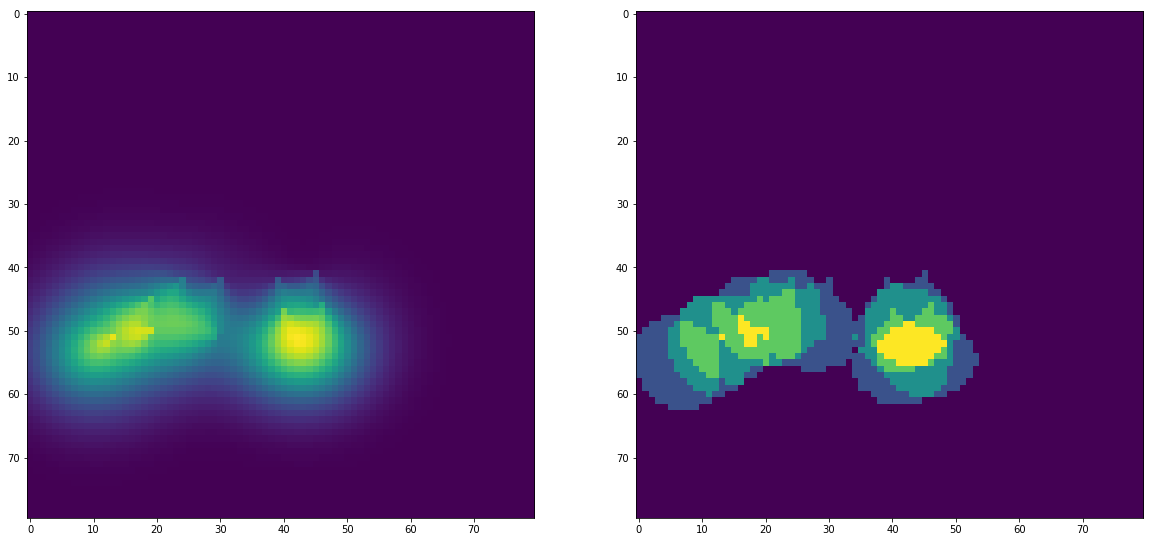

weighted accum map


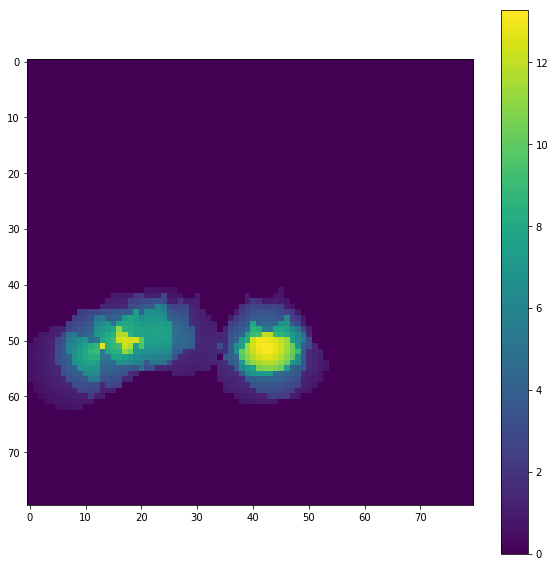

region


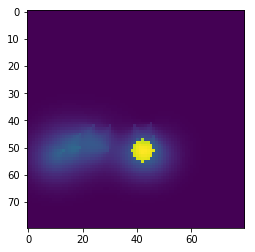

roundN 1 memberShip: [7, 10, 12, 13]
remain for next round


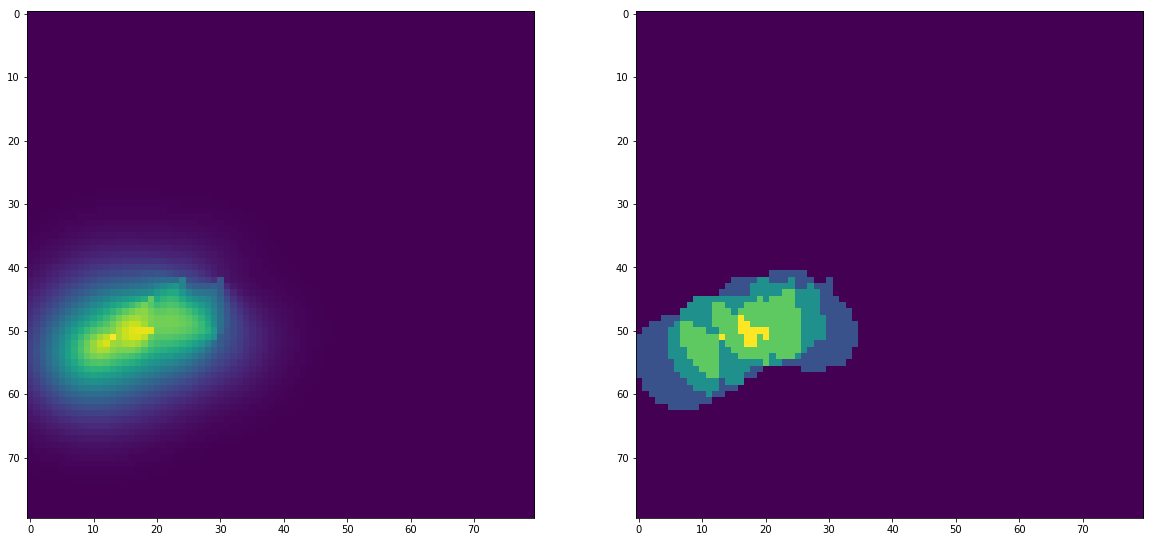

weighted accum map


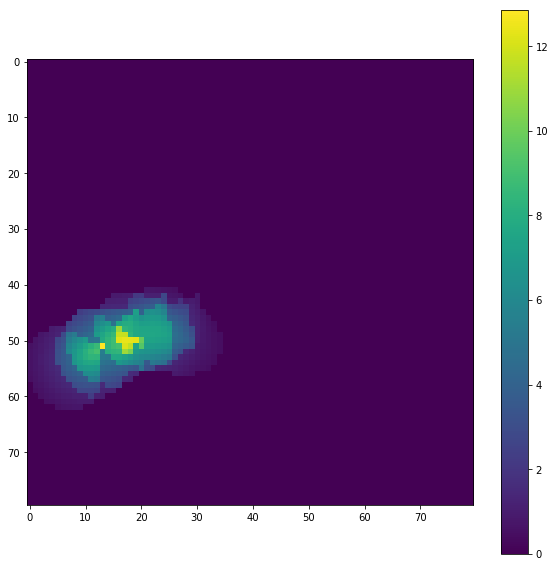

region


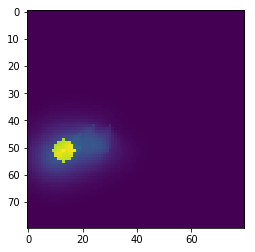

roundN 2 memberShip: [8, 11, 14, 15, 16]
remain for next round


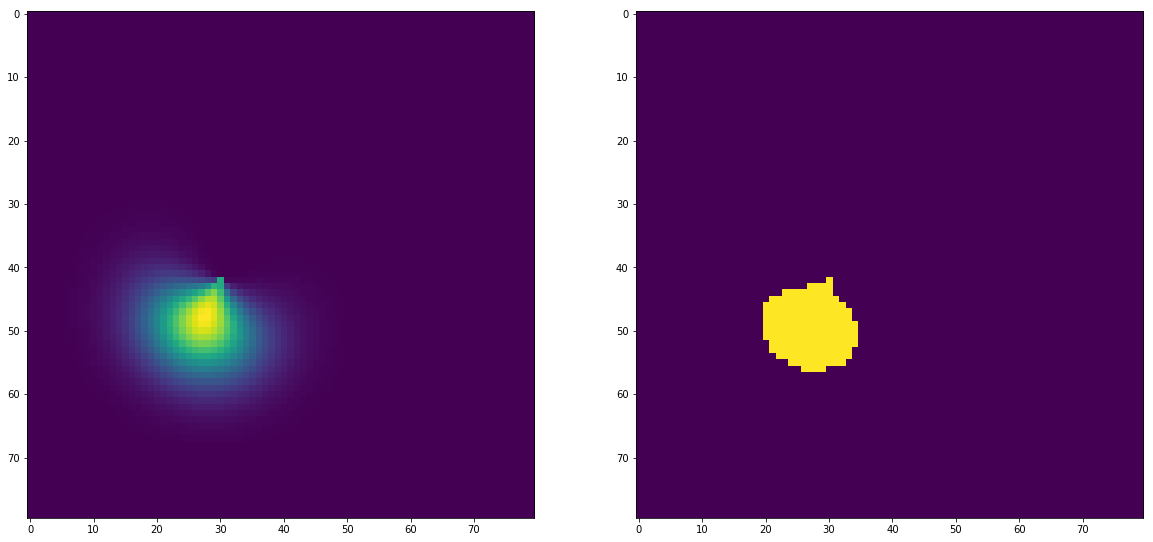

weighted accum map


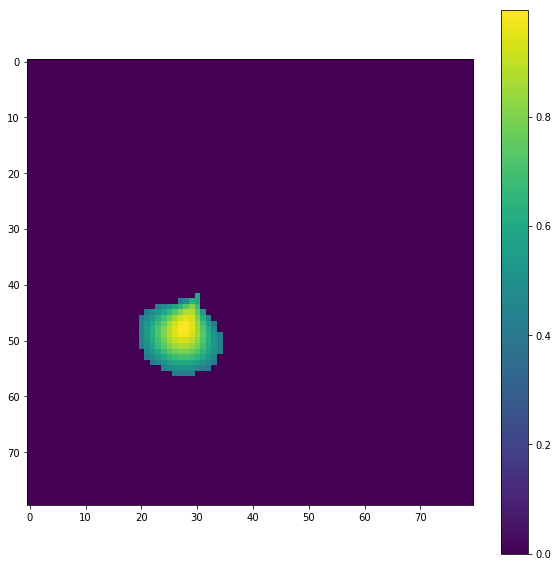

region


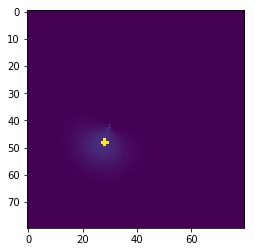

roundN 3 memberShip: [9]
remain for next round


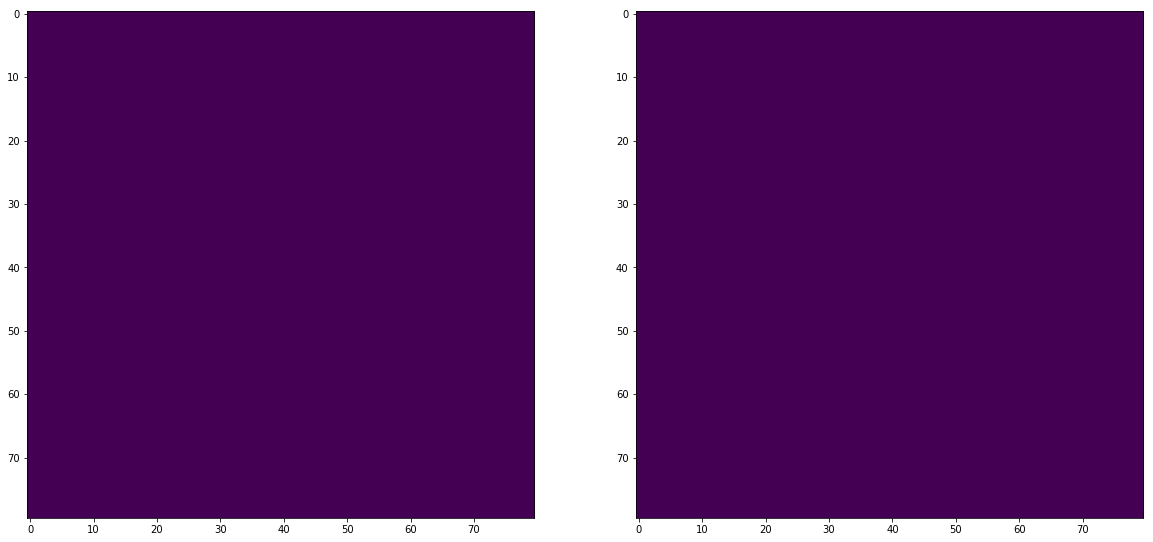

n_dets = 16, n_gts = 18


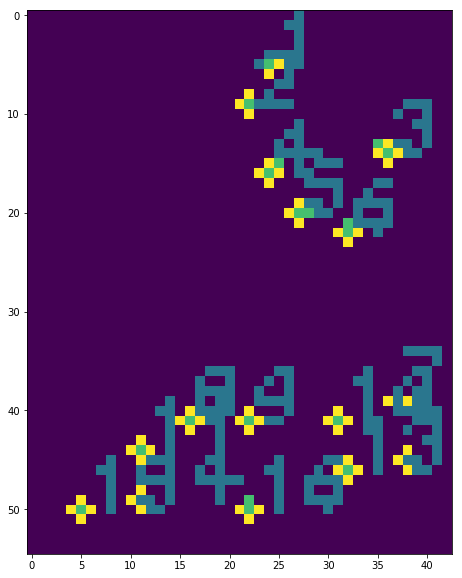

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7 10 13 14 15] Ids [9, 10, 16, 15, 14]
members [8] Ids [11]


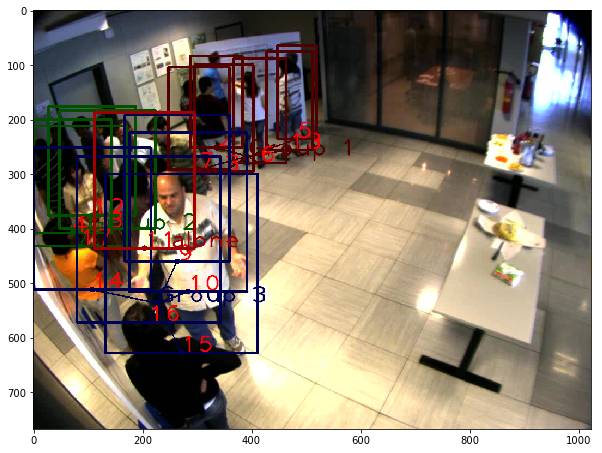

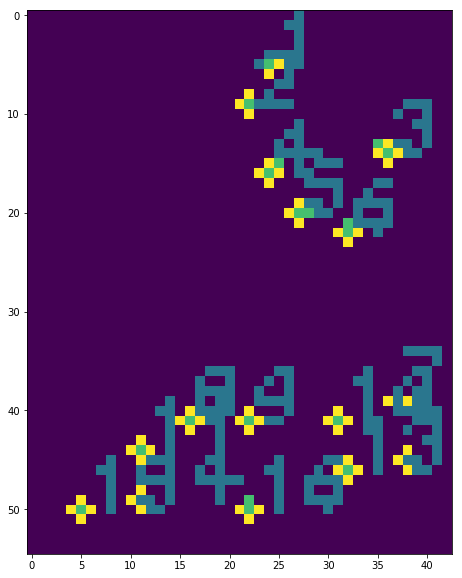

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7 10 13 14 15] Ids [9, 10, 16, 15, 14]
members [8] Ids [11]


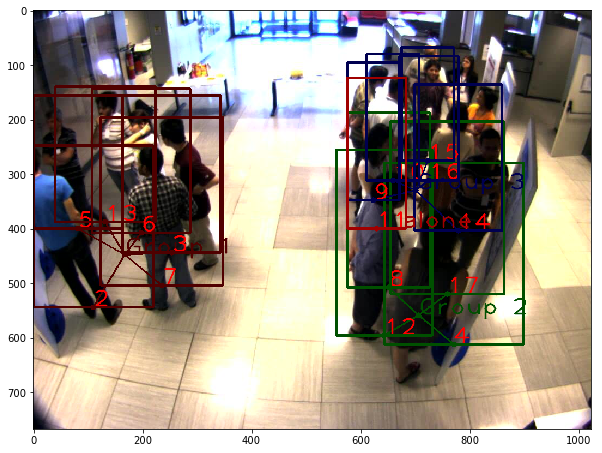

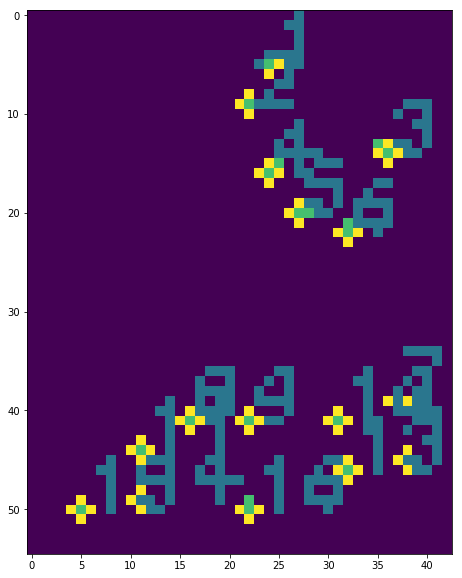

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7 10 13 14 15] Ids [9, 10, 16, 15, 14]
members [8] Ids [11]


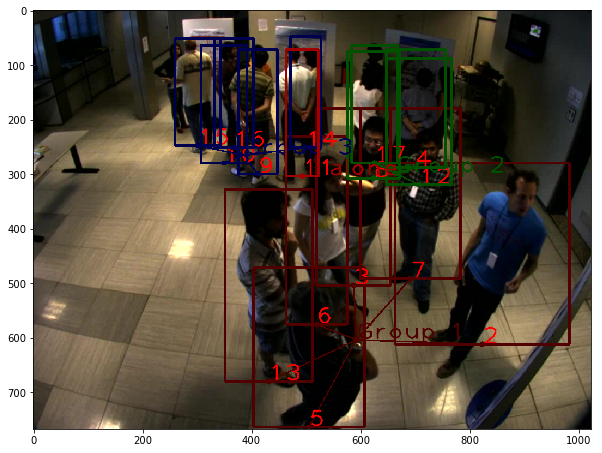

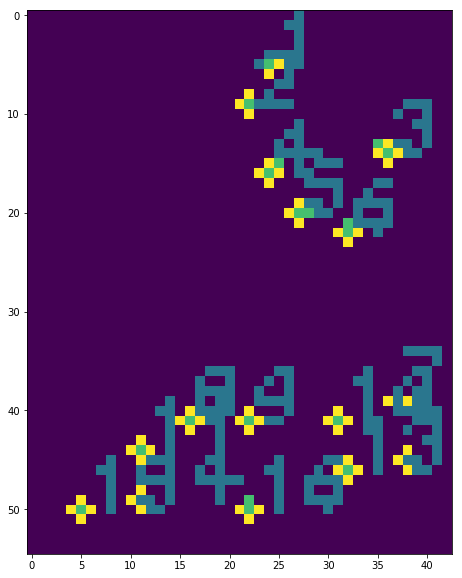

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7 10 13 14 15] Ids [9, 10, 16, 15, 14]
members [8] Ids [11]


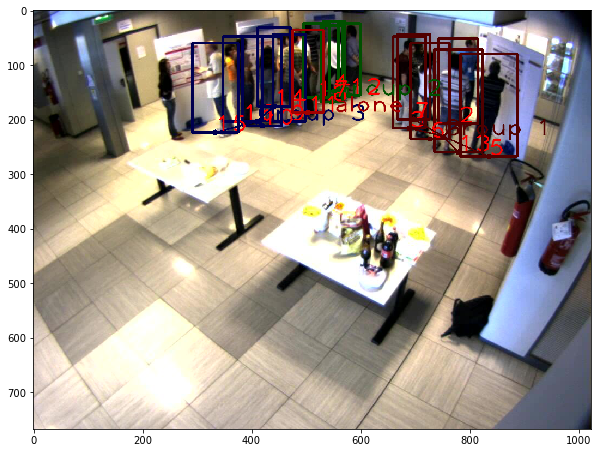

rest [[11]]
matched [[12, 8, 4, 17], [5, 13, 2, 6, 3, 7], [9, 10, 16, 15, 14]]
final members [[5, 13, 2, 6, 3, 7], [12, 8, 4, 17], [9, 10, 16, 15, 14], [11]]
GT FFormation [[8, 12, 17, 4], [1], [2, 13, 7, 3, 6, 5], [15, 9, 11, 16, 18, 10, 14]]
TP, FP, FN 3 1 1
sigma_r = 1.000000, threshold = 0.400000, kernel size = 25, F1 score = 0.750000
FID 0, cam 0
FID 0, cam 1
FID 0, cam 2
FID 0, cam 3
accum map


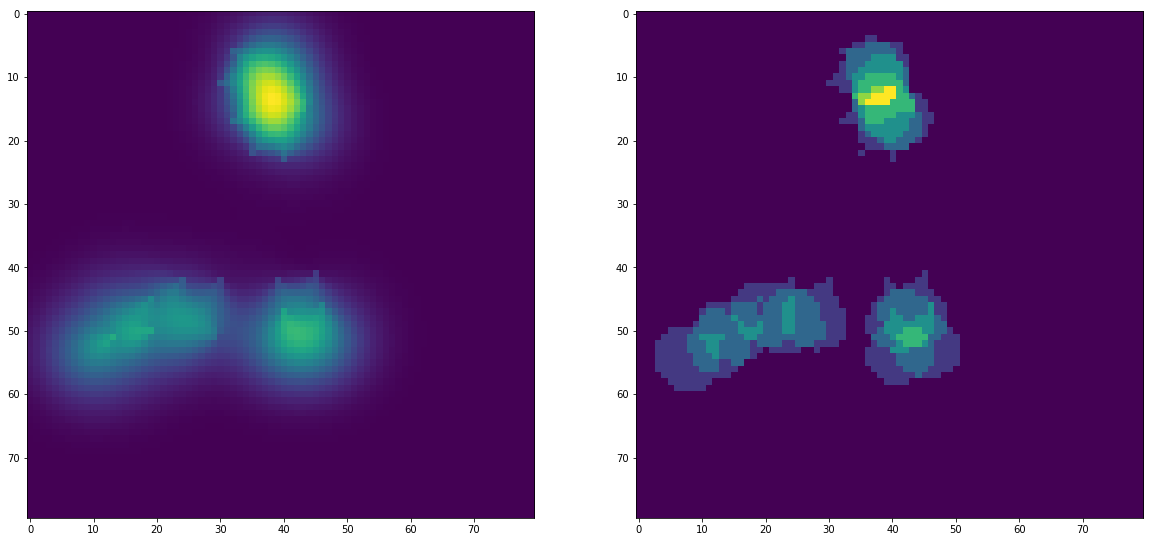

weighted accum map


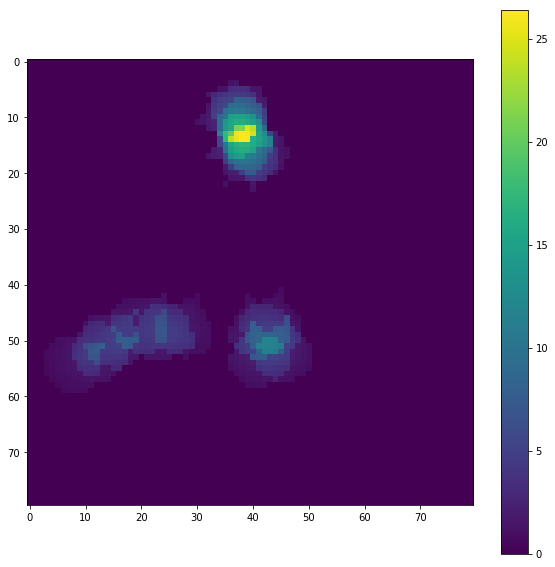

region


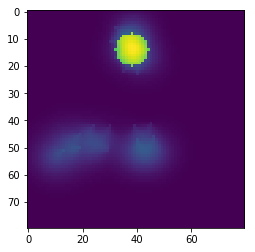

roundN 0 memberShip: [1, 2, 3, 4, 5, 6]
remain for next round


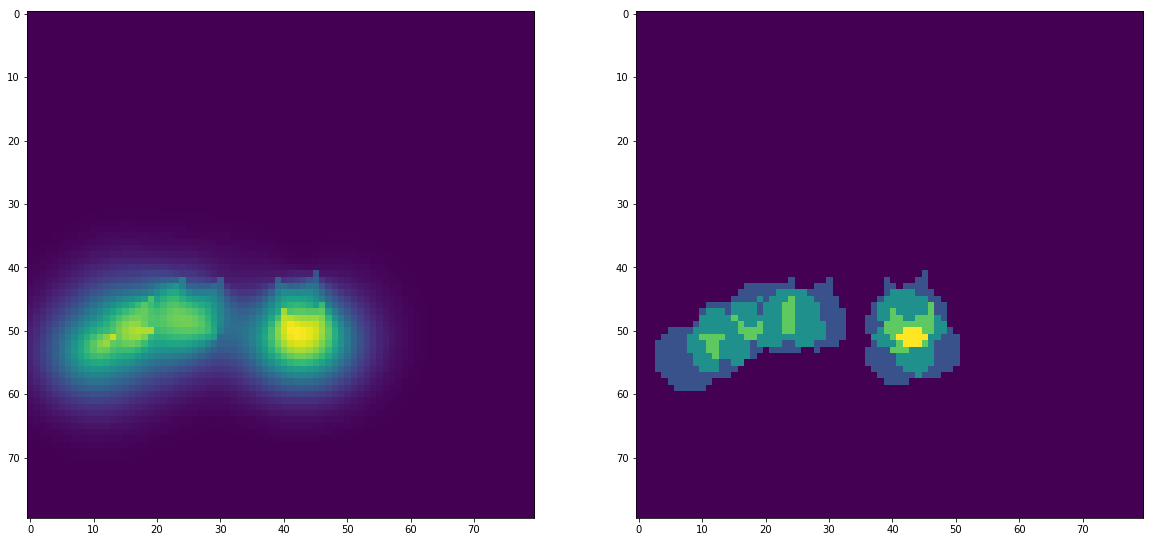

weighted accum map


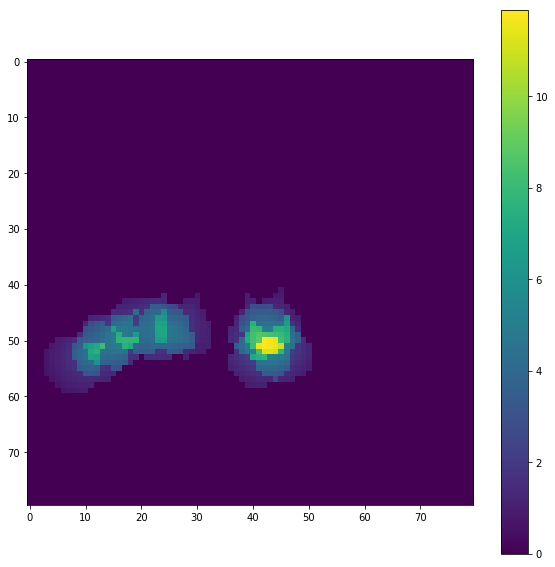

region


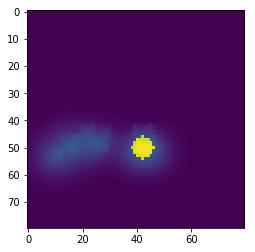

roundN 1 memberShip: [7, 10, 12, 13]
remain for next round


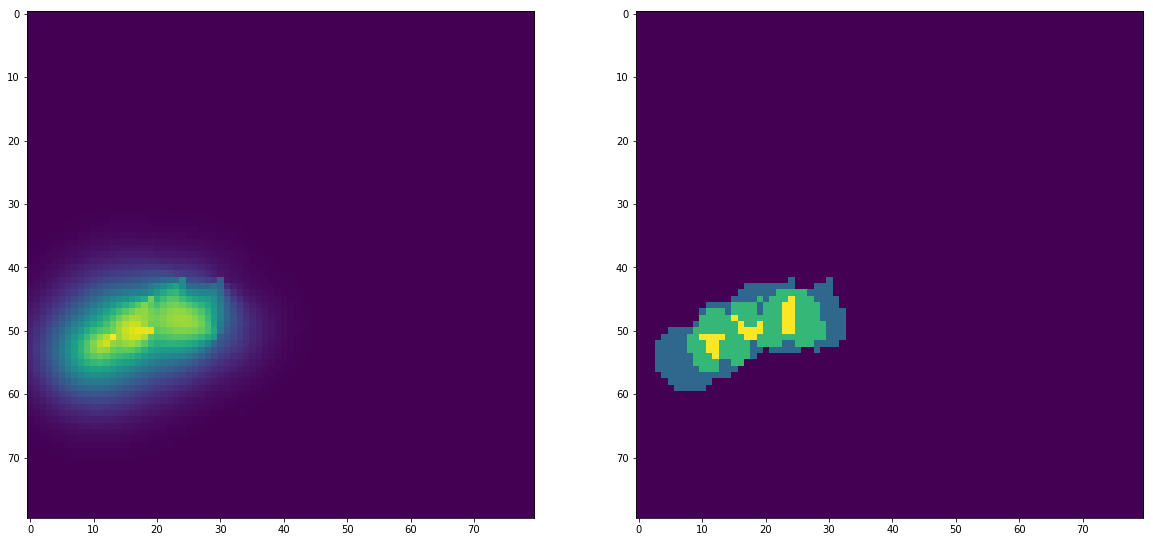

weighted accum map


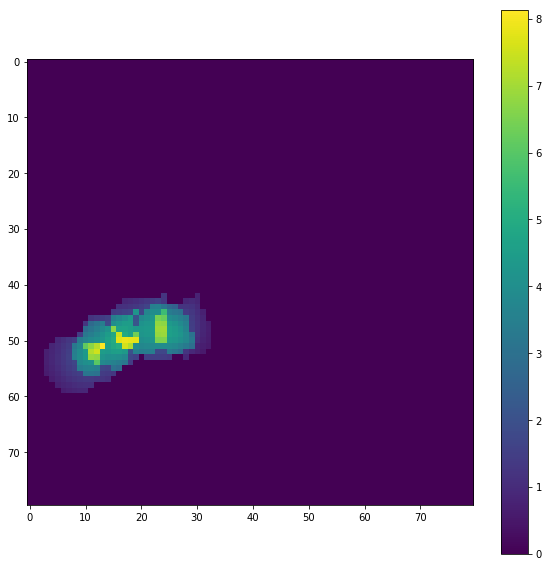

region


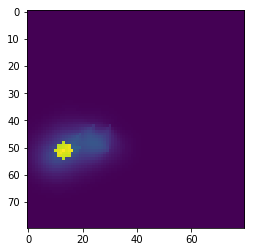

roundN 2 memberShip: [11, 14, 15]
remain for next round


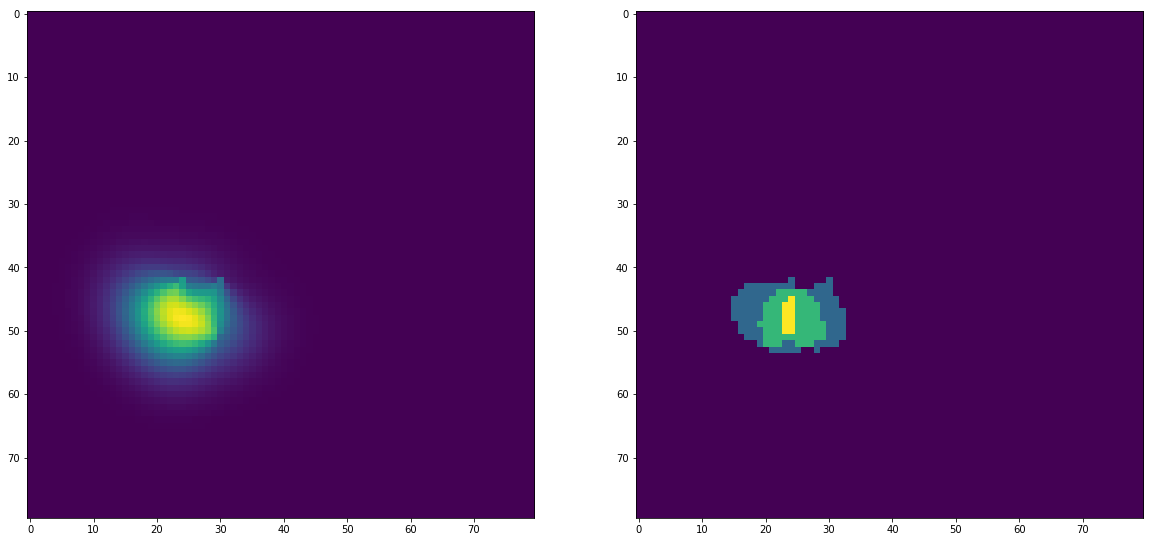

weighted accum map


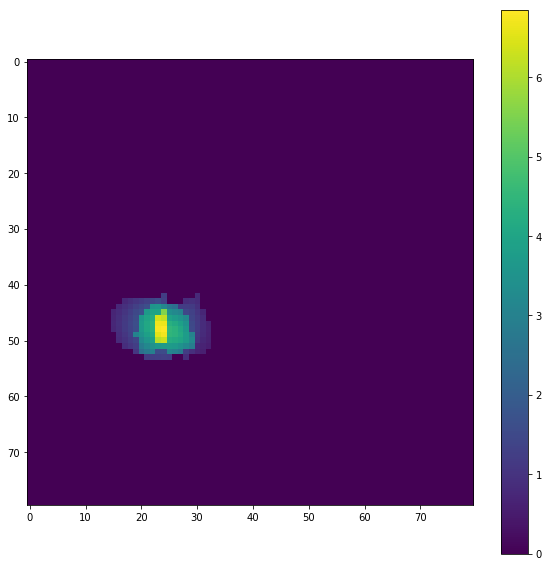

region


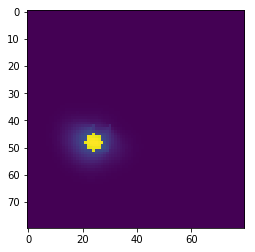

roundN 3 memberShip: [8, 9, 16]
remain for next round


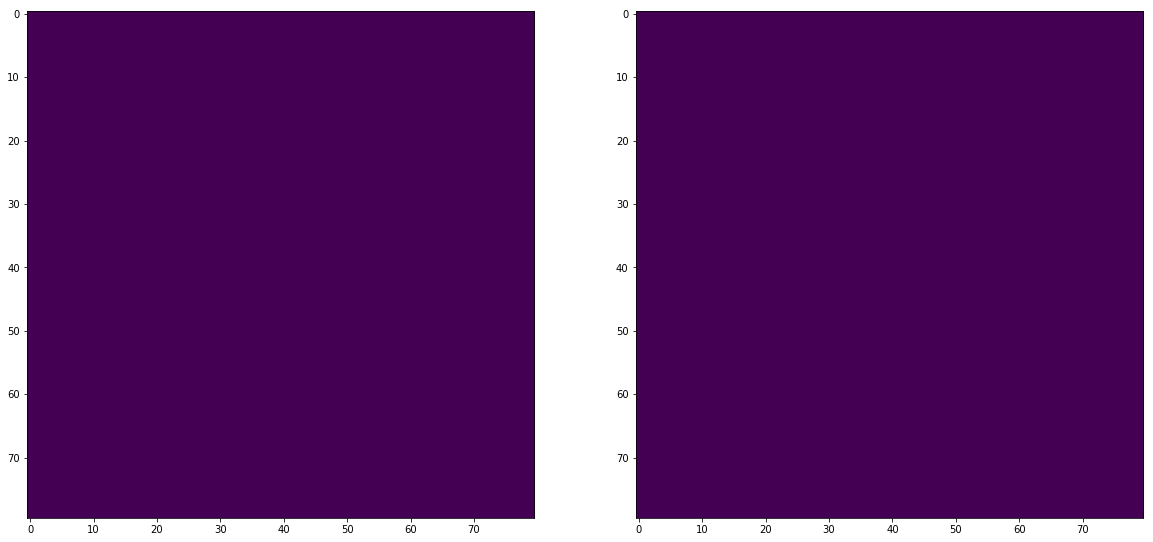

n_dets = 16, n_gts = 18


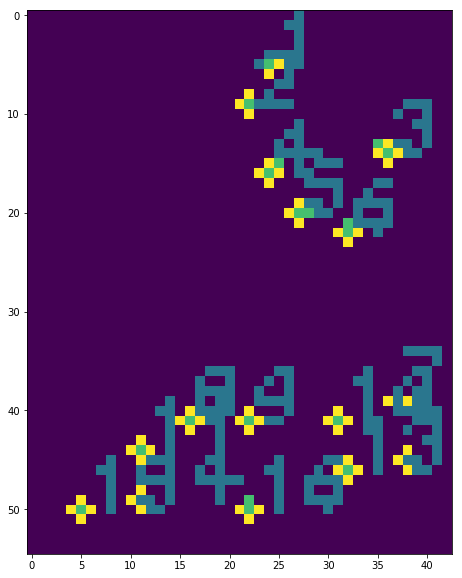

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [10 13 14] Ids [10, 16, 15]
members [ 7  8 15] Ids [9, 11, 14]


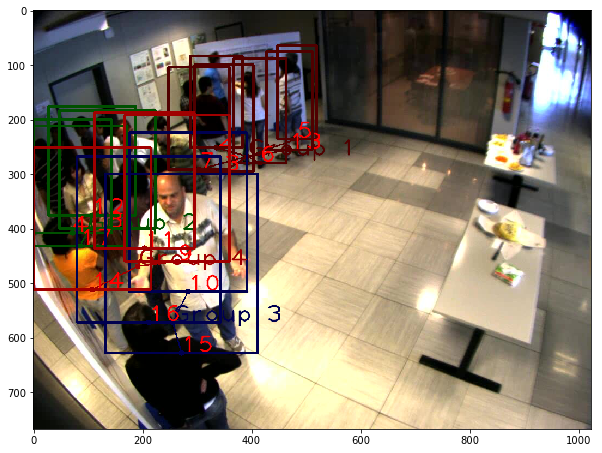

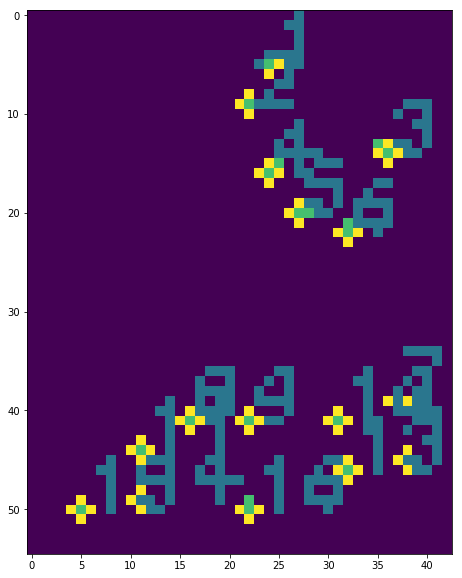

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [10 13 14] Ids [10, 16, 15]
members [ 7  8 15] Ids [9, 11, 14]


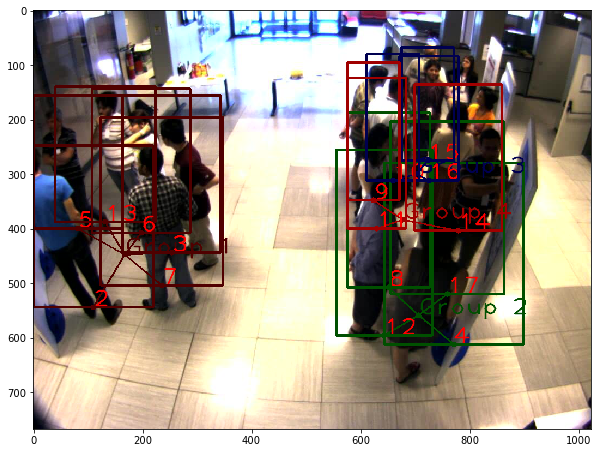

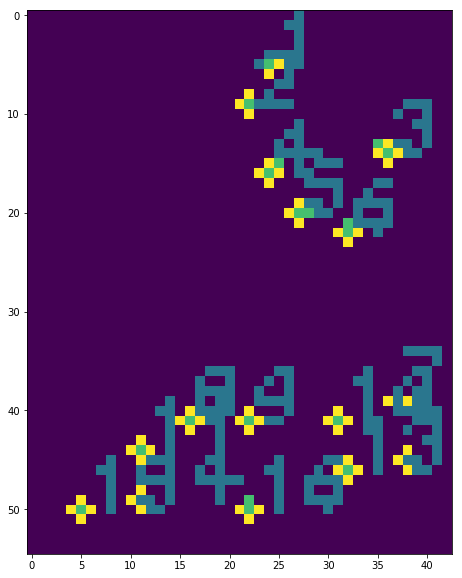

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [10 13 14] Ids [10, 16, 15]
members [ 7  8 15] Ids [9, 11, 14]


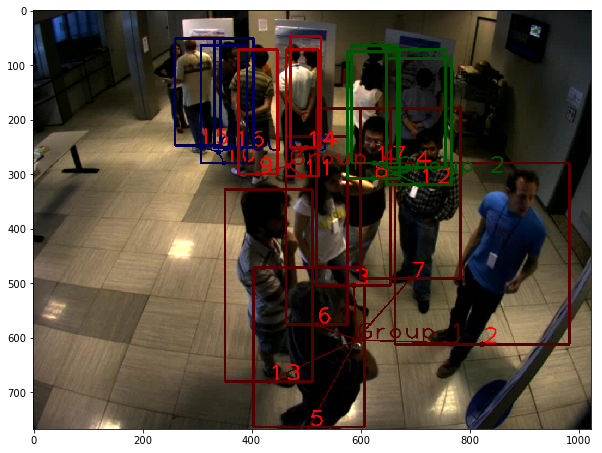

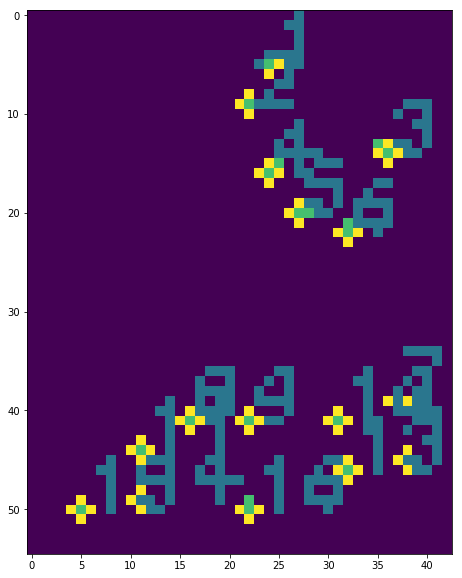

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [10 13 14] Ids [10, 16, 15]
members [ 7  8 15] Ids [9, 11, 14]


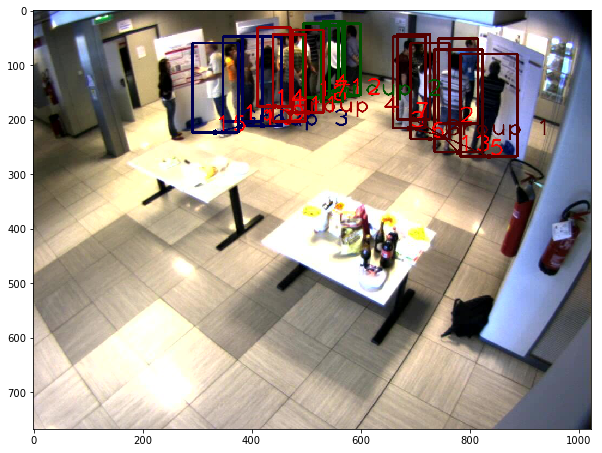

rest [[10, 16, 15], [9, 11, 14]]
matched [[12, 8, 4, 17], [5, 13, 2, 6, 3, 7]]
final members [[5, 13, 2, 6, 3, 7], [12, 8, 4, 17], [10, 16, 15], [9, 11, 14]]
GT FFormation [[8, 12, 17, 4], [1], [2, 13, 7, 3, 6, 5], [15, 9, 11, 16, 18, 10, 14]]
TP, FP, FN 2 2 2
sigma_r = 1.000000, threshold = 0.500000, kernel size = 21, F1 score = 0.500000
FID 0, cam 0
FID 0, cam 1
FID 0, cam 2
FID 0, cam 3
accum map


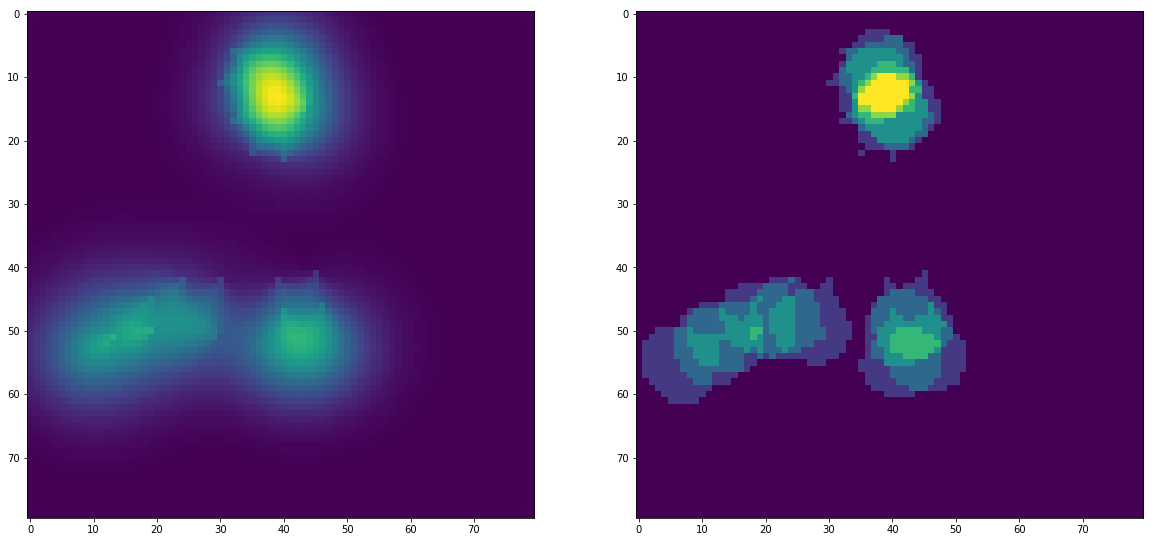

weighted accum map


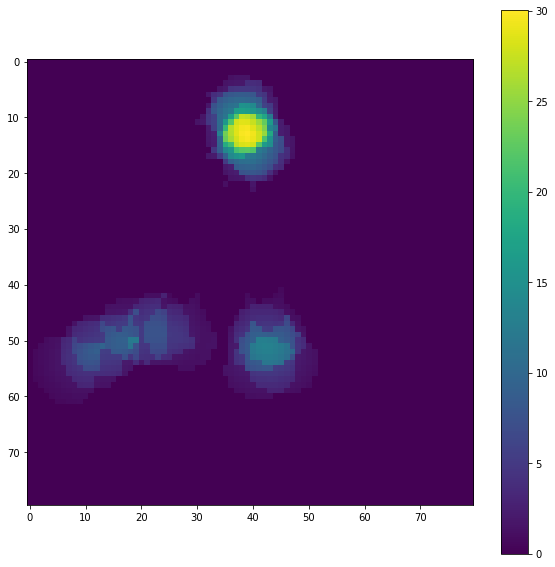

region


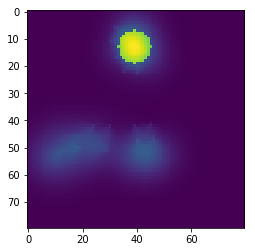

roundN 0 memberShip: [1, 2, 3, 4, 5, 6]
remain for next round


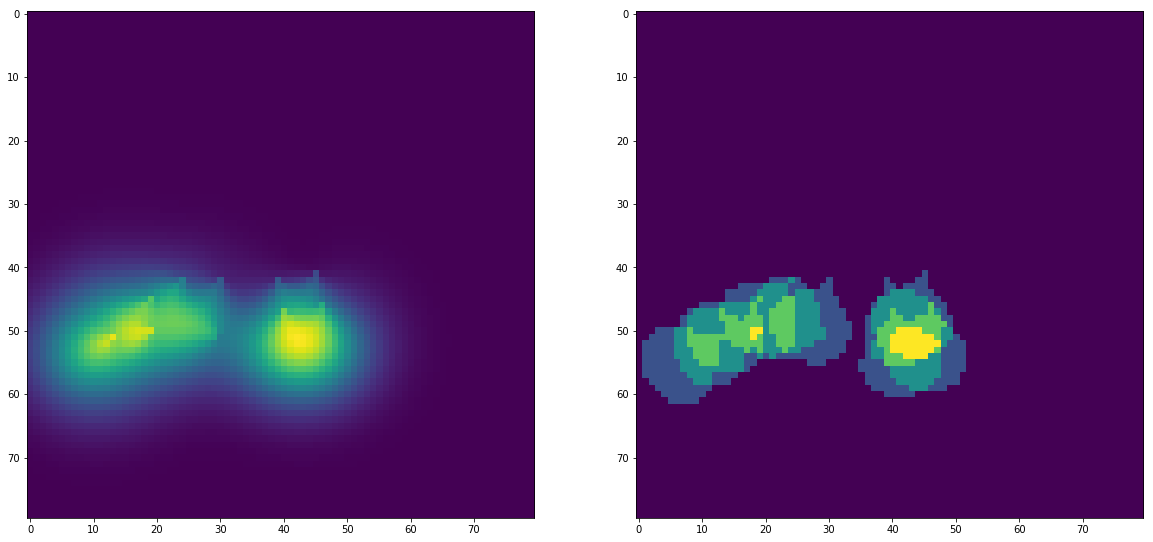

weighted accum map


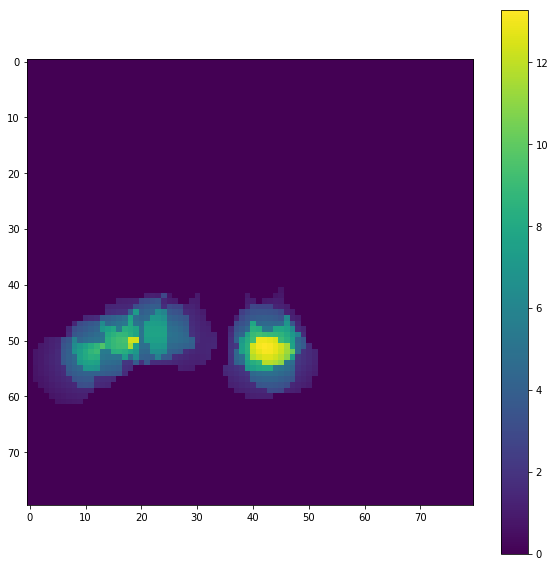

region


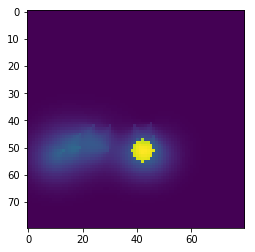

roundN 1 memberShip: [7, 10, 12, 13]
remain for next round


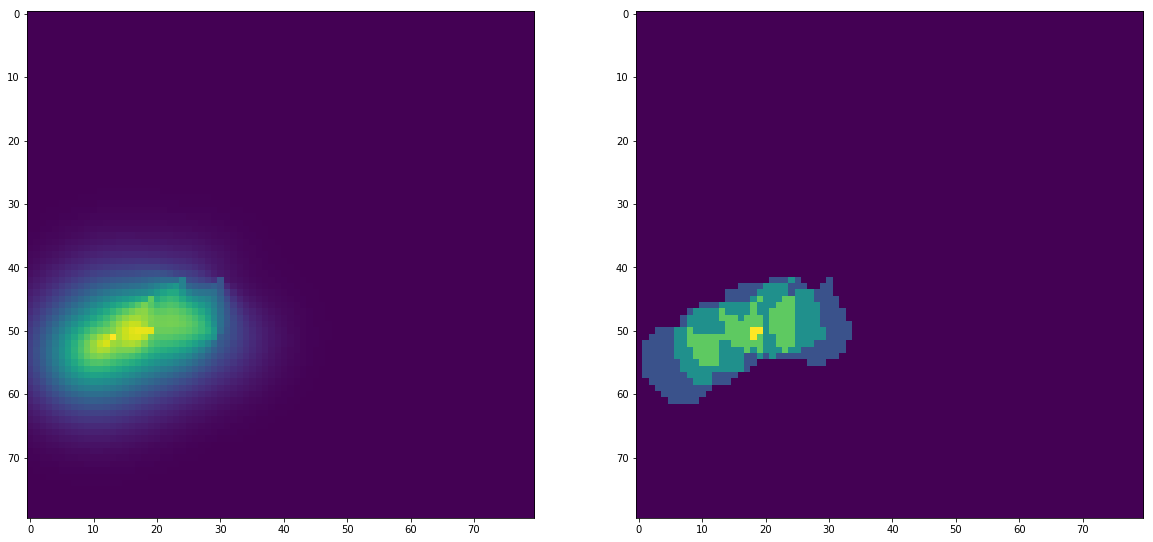

weighted accum map


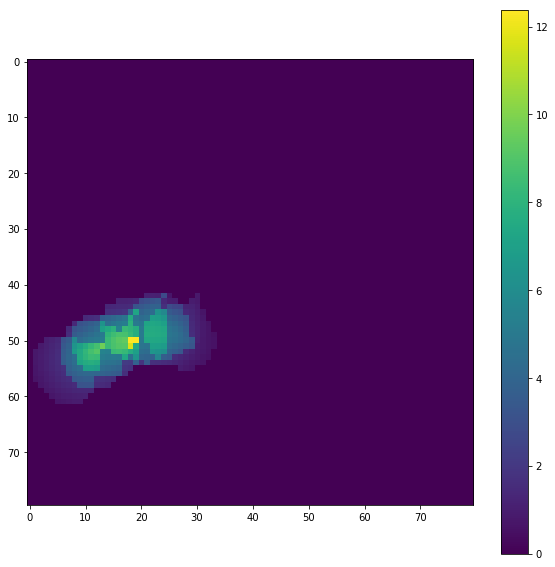

region


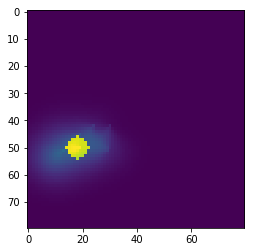

roundN 2 memberShip: [8, 9, 11, 14, 16]
remain for next round


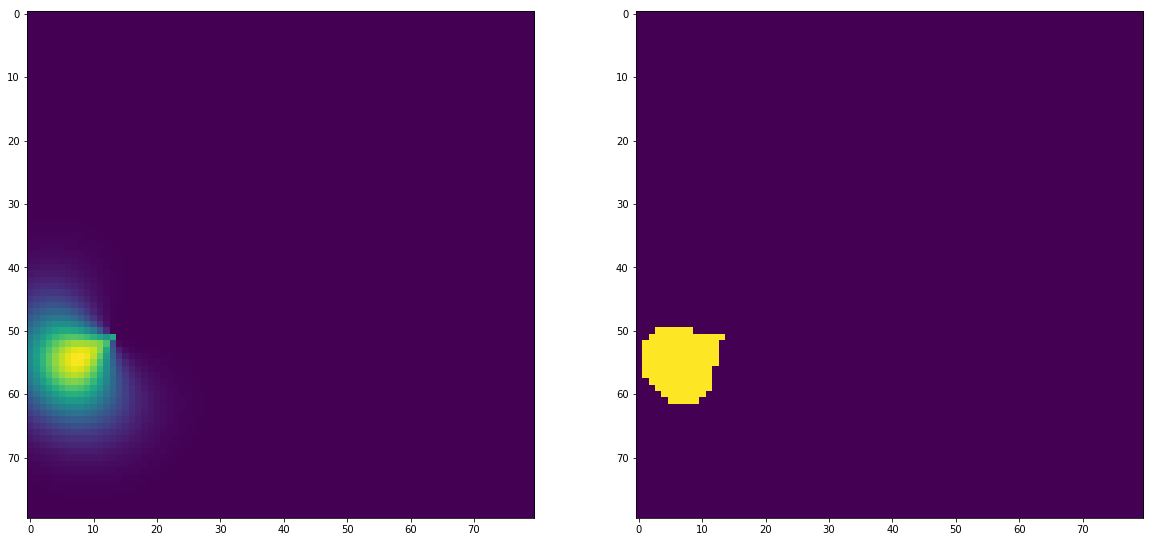

weighted accum map


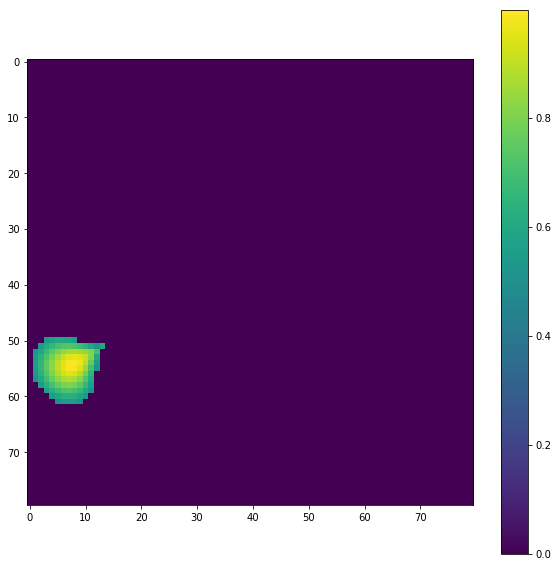

region


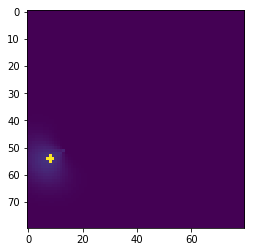

roundN 3 memberShip: [15]
remain for next round


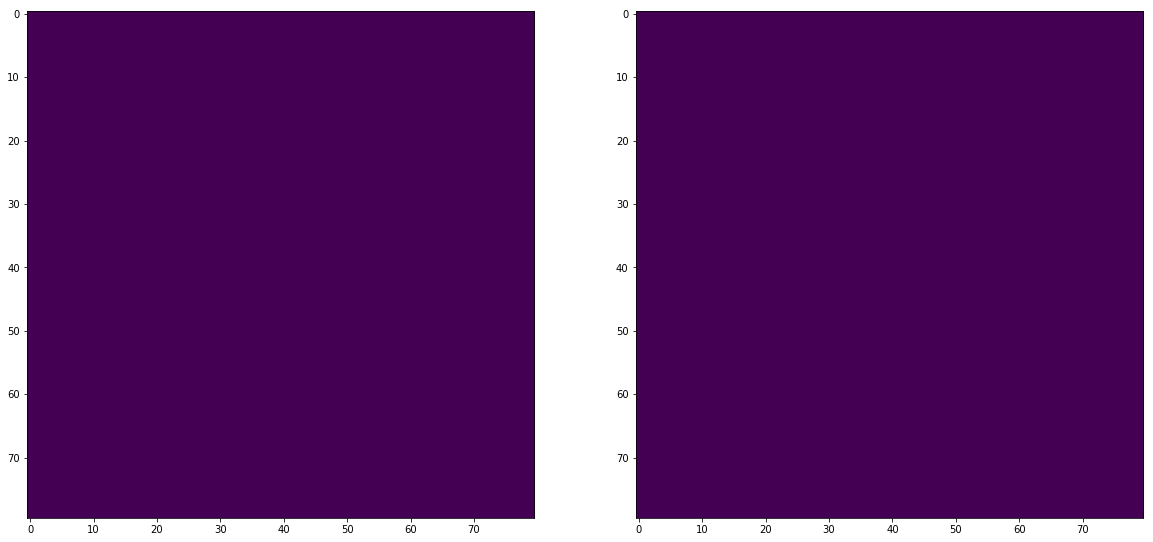

n_dets = 16, n_gts = 18


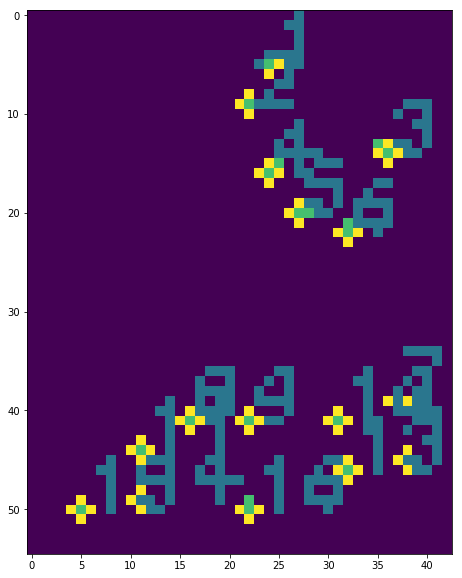

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


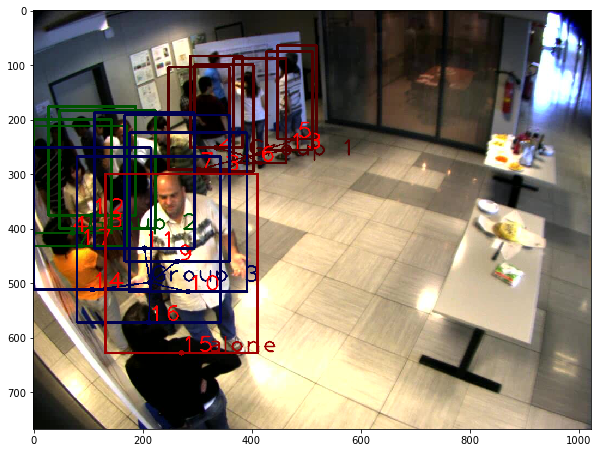

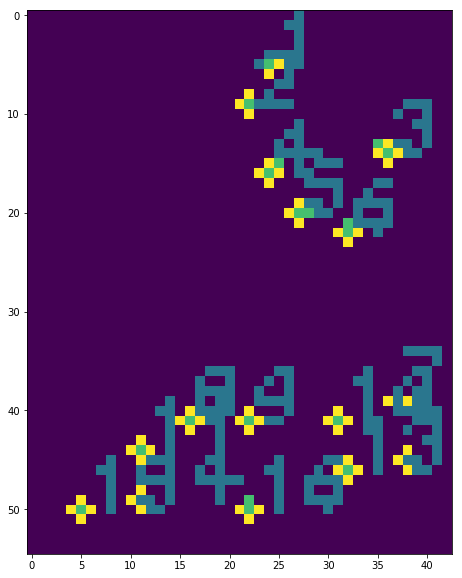

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


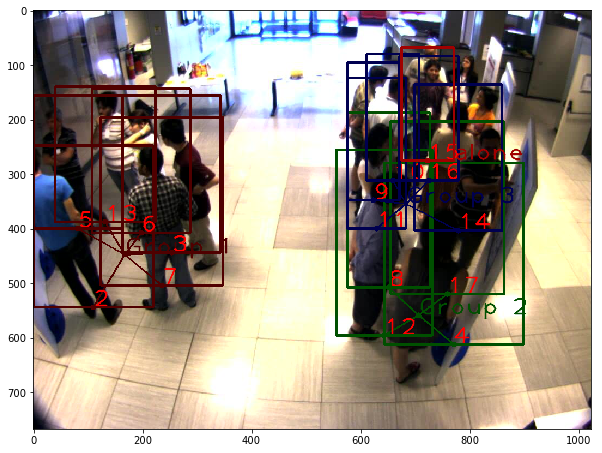

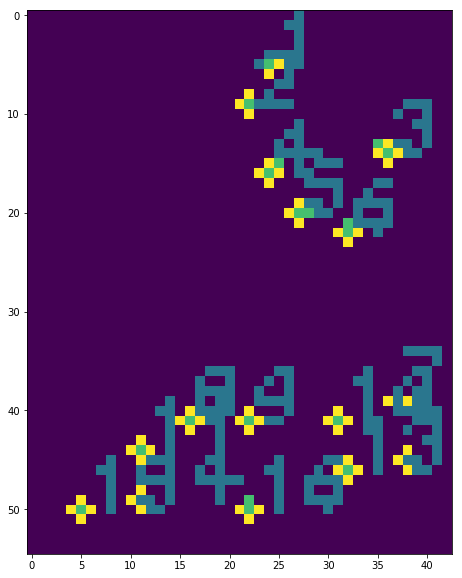

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


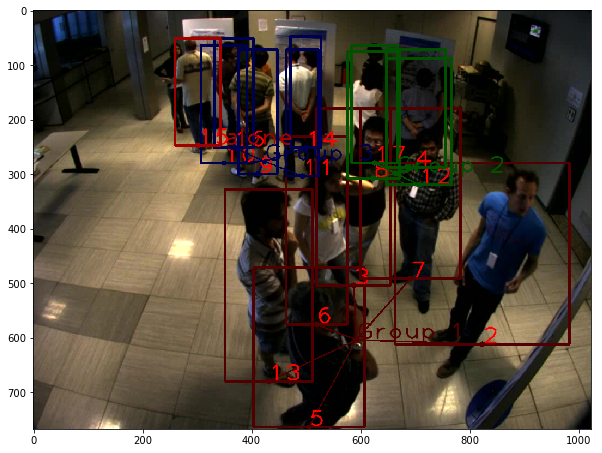

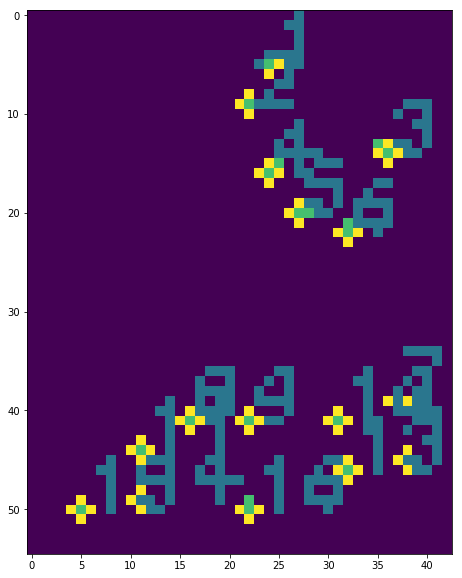

members [0 1 2 3 4 5] Ids [5, 13, 2, 6, 3, 7]
members [ 6  9 11 12] Ids [12, 8, 4, 17]
members [ 7  8 10 13 15] Ids [9, 11, 10, 16, 14]
members [14] Ids [15]


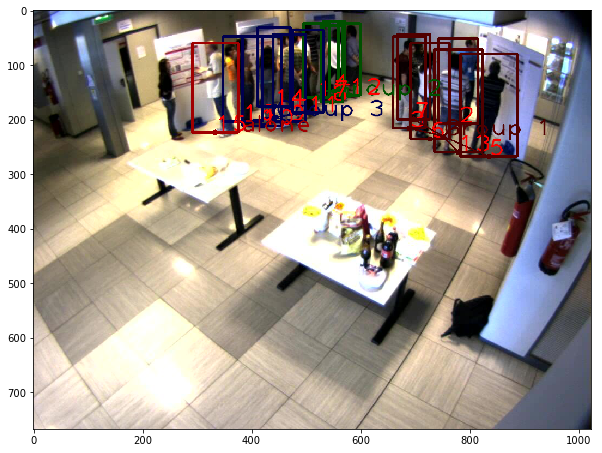

rest [[15]]
matched [[12, 8, 4, 17], [5, 13, 2, 6, 3, 7], [9, 11, 10, 16, 14]]
final members [[5, 13, 2, 6, 3, 7], [12, 8, 4, 17], [9, 11, 10, 16, 14], [15]]
GT FFormation [[8, 12, 17, 4], [1], [2, 13, 7, 3, 6, 5], [15, 9, 11, 16, 18, 10, 14]]
TP, FP, FN 3 1 1
sigma_r = 1.000000, threshold = 0.500000, kernel size = 25, F1 score = 0.750000


In [11]:
frame_num =1
start = 0
stride = 2

show=False
showVoting = False

#Try different parameters
#when use GT detection and orientation, 1.0, 0.5, 21 gives F1=0.97
sigma_rs = [1.0]
thresholds = [0.4, 0.5]
k_sizes = [21, 25]
clusterWay = 'region'

for sigmaR in sigma_rs:
    for thres in thresholds:
        for k_size in k_sizes:
            TPs = 0
            FPs = 0
            FNs = 0
            for fid in range(start,start+frame_num*stride, stride):
                gt_line = (Config.img_index_list[fid] - 3) / 45
                if fid%30 == 0: #visualize
                    show=True
                    showVoting=True

                #load rectID for all detected targets on POM ground
                detections = load_detections(fid)

                #get detection's position on POM ground
                H_grid = Config.H_grid
                pts_POM_2d = recID2coord(detections, H_grid)
                #extend to 3d coordinate
                pad = np.zeros((pts_POM_2d.shape[0],1))
                pts_POM = np.concatenate((pts_POM_2d, pad), axis = 1)

                #get GT position for matching in later step
                GTdetections = all_detections[:,gt_line] #GT detection
                GT_POM_2d = recID2coord(GTdetections, H_grid)

                #To save estimated angle vectors from different views
                ESTOriPts_cam = np.zeros(( len(Config.cameras_list), len(detections), 2 ))

                #To save images and RoIs for visualizing
                rois = []
                x_imgs = []
                y_imgs = []
                for cam in Config.cameras_list:
                    #GT_b = GT_b_camSpace[cam, gt_line, :]
                    print 'FID %d, cam %d'%(fid,cam)
                    x = unaryModel.get_rgb(fid,cam) #fid is the index of img_index_list

                    #get GT bbox from pom
                    rois_GT = extractBoxes(cam, detections)
                    x_imgs.append((rois_GT[:,1]+rois_GT[:,3])*0.5*Config.CNN_factor)
                    y_imgs.append(rois_GT[:,4]*Config.CNN_factor)
                    rois.append(rois_GT)
                    p_out, estimate_rad = unaryModel.run_func(x, rois_GT)#run function to estimate orientation
                    #rgb = unaryModel.visualize_batch(x, rois_GT)
                    
                    #Get people's position in cam space
                    RzT = RzTs[cam]
                    pts_cam = geoFuncs.world2camRz(pts_POM.transpose(), RzT)#input pts should be 3*N
                    #Get people's orientation in cam space
                    b_vec = geoFuncs.pointsOnUnitWithCenter(pts_cam.transpose(), estimate_rad[:,0])
                    #transform to world coordinate and save the estimated angles in world coordinate
                    pts_world = geoFuncs.projBack2World(pts_cam, RzT)
                    ptsB_w = cam2dToWorld3d(b_vec, RzT)
                    #record
                    ESTOriPts_cam[cam, :, :] = ptsB_w

                #integrate views
                aveESTOriPts = np.mean(ESTOriPts_cam, axis=0)
                aveESTOriPts_world = np.concatenate( (aveESTOriPts, np.zeros((aveESTOriPts.shape[0],1))), axis = 1 )
                groundEST, ESTpts_shift, ESTend_pts_shift = drawLib.drawLinesOnGround(pts_world.transpose(), [aveESTOriPts_world], 1)
                # vec to angle
                ori = aveESTOriPts - pts_world.transpose()[:,0:2]
                ang_b = geoFuncs.angle_rads( np.array([1,0]), ori )
                
                #Vote for Grouping
                sigmaA = 0.7
                r_mu = 1.
                groundPOM = np.zeros((Config.H_grid, Config.W_grid))
                voteMaps, voteCountMaps = GroupCluster.buildMaps(groundPOM, pts_POM, ang_b, sigmaR, sigmaA, k_size, r_mu, thres)
                membersEST = GroupCluster.Voting(voteMaps, voteCountMaps,  show = showVoting)

                #match detection
                detID = GroupCluster.hungarian_matching(GT_POM_2d, pts_POM_2d)
                membership = []
                for group in membersEST:
                    newG = []
                    for member in group:
                        newG.append( int(detID[member-1][0]) )
                    membership.append(newG)

                if show:
                    for c in Config.cameras_list:
                        plt.figure(figsize=(10,10))
                        plt.imshow(groundEST)
                        plt.show()

                        bboxs = rois[c]
                        x_img = x_imgs[c]
                        y_img = y_imgs[c]
                        #draw membership
                        rgbImg = drawLib.drawBoxMembershipImg( membersEST, membership, bboxs, x_img, y_img, fid, c)
                        #draw orientation
                        showOrien(c, ang_b, x_img, y_img, rgbImg)
                        show=False
                        showVoting=False
                #evaluate
                ffGTList = ffGTs[gt_line]
                
                TP, FP, FN = GroupCluster.evaluate(ffGTList,membership)
                TPs += TP
                FPs += FP
                FNs += FN
                print 'final members', membership
                print 'GT FFormation', ffGTList
                print 'TP, FP, FN', TP, FP, FN
            
            #record evaluation result
            epi = 1.e-17
            precisions = TPs/ (TPs+FNs+epi)
            recalls = TPs/ (TPs+FPs+epi)
            F1 = 2*precisions*recalls/(precisions+recalls+epi)
            print 'sigma_r = %f, threshold = %f, kernel size = %d, F1 score = %f'%(sigmaR, thres, k_size, F1)
            with open('FFresults_estInputs%s.csv'%clusterWay, 'a') as f:
                wResult = csv.writer(f)
                wResult.writerow([sigmaR, sigmaA, thres, k_size, TPs, FPs, FNs, F1, precisions, recalls])
            